#### Did the office lose popularity or viewership when transfering to Peacock?
Let's look at the activity on the DunderMifflin subreddit as a proxy for The Office popularity/interaction and explore trends and the effect of it's move to Peacock.

##### Hypothesis :
When The Office moved to an exclusive on Peacock, less viewers had access and this will be noted with a decrease in activity on the Dunder Mifflin subreddit after transition.<br>
(Null hypothesis: activity on the DM subreddit is unchanged after the transition date.)

##### Questions:
- Did comment or score levels change before/after transition from Netflix to Peacock?
- What can we infer from some of the posting patterns?
- Is there a seasonal trend to the posts? More popular days of the week?

##### Challenges:
- Reddit API cannot return every post, we are limited to top posts of last year or all time (not date ranges) and there is a 1000 post limit
- This means we have a biased dataset, not a full view of subreddit activity
- We do not have a history of number of users to explore popularity or normalize activity (could check https://subredditstats.com/ in the future)
- Normalization is difficult since top posts is biased, some days will have no posts, some multiple. *Particularly bad on the all time dataset*

#### Summary of results:
- As of publication of 1/27/21, there is not enough post-transition data to show trends of activity changing
    - Revisit as more data is available
- There was a bump of comment activity within a few days of the transition, both before and after
- Wednesday seems to be the most popular day for posting on the subreddit
- Unable to extract a yearly seasonal trend on the data, but someone with more experience may be able to solve it

In [1]:
import praw
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

transition = pd.to_datetime('1/1/2021').tz_localize('US/Pacific')  # Date that The Office left Netflix for Peacock

In [2]:
_="""
I'm hiding my API credentials!
but if you are recreating this here's how it would go:
Influenced by https://www.storybench.org/how-to-scrape-reddit-with-python/

import praw
reddit = praw.Reddit(client_id='PERSONAL_USE_SCRIPT_14_CHARS', \
                     client_secret='SECRET_KEY_27_CHARS ', \
                     user_agent='YOUR_APP_NAME', \
                     username='YOUR_REDDIT_USER_NAME', \
                     password='YOUR_REDDIT_LOGIN_PASSWORD')

reddit.read_only = True     # Don't risk any writing
subreddit = reddit.subreddit('DunderMifflin')
top_all = subreddit.top(time_filter='all',limit=None)
top_year = subreddit.top(time_filter='year',limit=None)
# The above are objects that are iterable as you'll see below
"""

In [3]:
# Here is my output from the API call, done in a separate script to hide it
from api_help import top_all, top_year

title, posted_epoch, num_com, vote = [],[],[],[]
for post in top_year:
    title.append(post.title)
    posted_epoch.append(post.created_utc)
    num_com.append(post.num_comments)
    vote.append(post.score)

df = pd.DataFrame({'title':title,'epoch':posted_epoch, 'num_comments':num_com,'score':vote})
df['created'] = pd.to_datetime(df['epoch'],unit='s', utc=True).dt.tz_convert('US/Pacific')

Password: ········


In [4]:
# We can also just import the pickled data from a previous API call
df = pd.read_pickle('dm_top_yearly_20210126.pkl')
df_all = pd.read_pickle('dm_top_alltime_20210126.pkl')
df['dayofweek'] = df['created'].dt.dayofweek
df_all['dayofweek'] = df_all['created'].dt.dayofweek

What does the distribution of scores and comments look like?

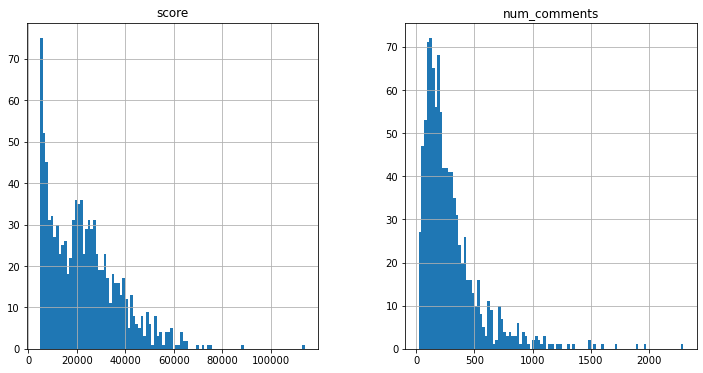

In [5]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
df.hist(column='score',bins=100,ax=axes[0])
_=df.hist(column='num_comments',bins=100,ax=axes[1])

<b> Above left: score looks mostly like an exponential distribution, but with a second peak around 20k score</b><br>
Does the redit scoring algorithm prefer scores near 20k?<br>
<b> Above right: number of comments looks like a lognormal distribution</b>
<br><br> Let's fit the distributions just for fun

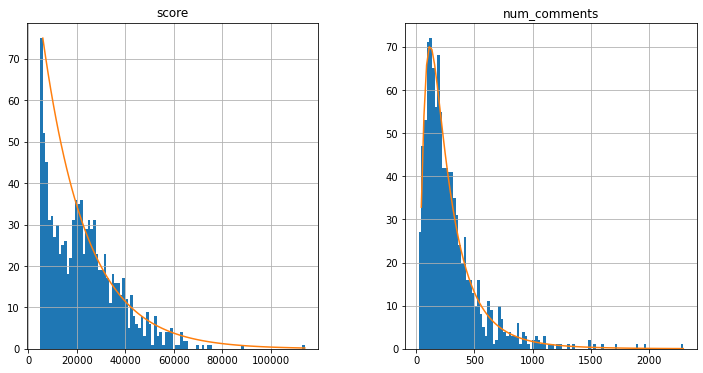

In [6]:
from scipy import stats
fig, axes = plt.subplots(1,2,figsize=(12,6))
df.hist(column='score',bins=100,ax=axes[0])
count,edges = np.histogram(df['score'],bins=100)
centers = np.diff(edges)+edges[:-1] # take bin value at center of bin
fit = stats.expon.fit(df['score'])
pdf = stats.expon.pdf(centers,fit[0],fit[1])
pdf = pdf/pdf.max()*75 # meet max scale
_=axes[0].plot(centers,pdf)

df.hist(column='num_comments',bins=100,ax=axes[1])
count,edges = np.histogram(df['num_comments'],bins=100)
centers = np.diff(edges)+edges[:-1] # take bin value at center of bin
fit = stats.lognorm.fit(df['num_comments'],loc=0)
pdf = stats.lognorm.pdf(centers,fit[0],fit[1],fit[2])
pdf = pdf/pdf.max()*70 # meet max scale
_=axes[1].plot(centers,pdf)

Exponential doesn't fit well on score because of second peak, but the lognormal does look pretty well representative of number of comments per post.

#### Time-Series look at Votes and Comments:

In [7]:
# Create new df that shows posts per day of the last year and normalize some stats
daily = pd.DataFrame({'num_posts':df.resample('D',on='created')['title'].count(),
                      'num_votes':df.resample('D',on='created')['score'].sum(),
                      'num_com':df.resample('D',on='created')['num_comments'].sum() })

daily['num_votes_norm'] = daily['num_votes']/daily['num_posts']
daily['num_com_norm'] = daily['num_com']/daily['num_posts']

# Roll, shift so that mean is at center of window, and drop last range which will not be properly sampled 
d30 = daily.rolling('30D', closed='right').mean().shift(-14,freq='D')[29:]
d7 = daily.rolling('7D',closed='right').mean().shift(-3,freq='D')[6:]

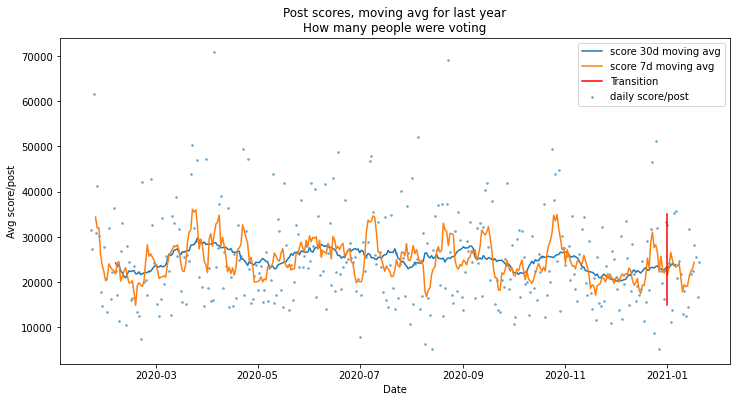

In [8]:
# Checking The Office activity from number of VOTES
x = 'num_votes_norm'  # The column we're using
plt.figure(figsize=(12,6))
plt.scatter(daily.index, daily[x],label='daily score/post',s=3,alpha=0.5)
plt.plot(d30.index,d30[x],label='score 30d moving avg')
plt.plot(d7.index,d7[x],label='score 7d moving avg')
plt.plot([transition,transition],[15000,35000],c='r',label='Transition')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Avg score/post')
_=plt.title('Post scores, moving avg for last year\nHow many people were voting')


#### Above: Based on number of upvotes to popular posts, there has not yet been a sizeable decline in activity
Running averages may be influenced by a couple highly-voted posts in the weeks before transition
Note that because only top posts can be queried, this isn't a random or full sample of activity

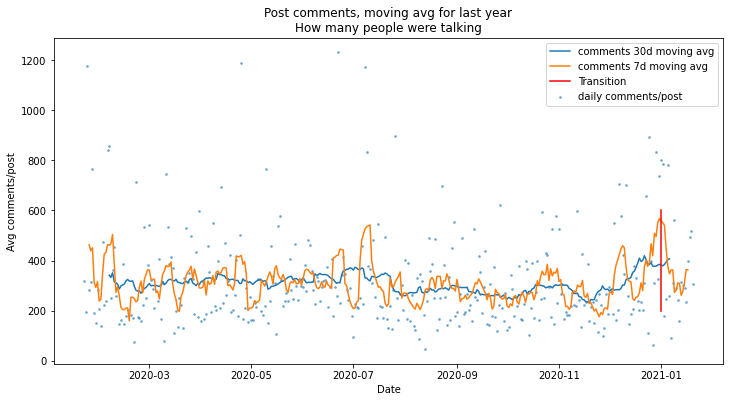

In [9]:
# Checking The Office activity from number of COMMENTS
x = 'num_com_norm'  # The column we're using
plt.figure(figsize=(12,6))
plt.scatter(daily.index, daily[x],label='daily comments/post',s=3,alpha=0.5)
plt.plot(d30.index,d30[x],label='comments 30d moving avg')
plt.plot(d7.index,d7[x],label='comments 7d moving avg')
plt.plot([transition,transition],[200,600],c='r',label='Transition')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Avg comments/post')
_=plt.title('Post comments, moving avg for last year\nHow many people were talking')


### Above: Comments on posts DOES seem to increase around transition date
This is influenced by a few posts both before and after transition date with high comment counts<br>
Presumably conversation is fueled by the transition and binge-watching at this time<br>
Need the data set to continue through Jan/Feb to notice further patterns

##### So what about seasonality?
Let's use top all-time data to look at trends. Remember this is a biased sample since it is just top posts (and this may be affected by subreddit active user base, which we don't have historic data for)

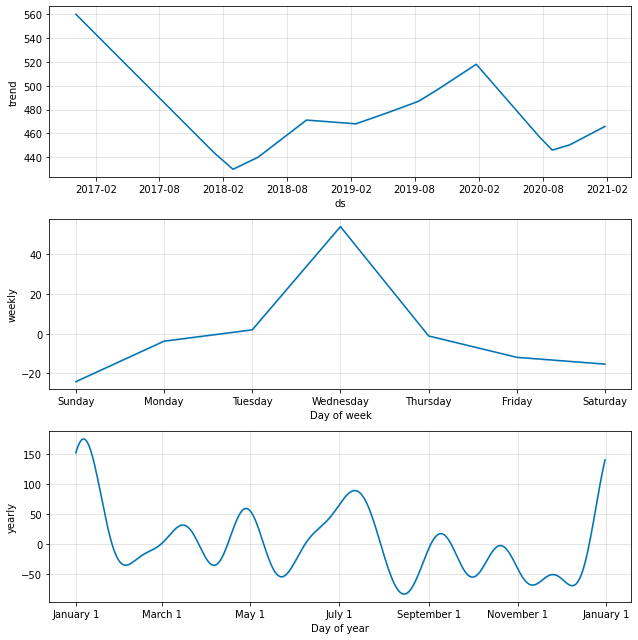

In [10]:
# Use Facebook Prophet for seasonality
# Inspired by Theristis paper and with help of his code https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9095267

daily_all = pd.DataFrame({'num_posts':df_all.resample('D',on='created')['title'].count(),
                      'num_votes':df_all.resample('D',on='created')['score'].sum(),
                      'num_com':df_all.resample('D',on='created')['num_comments'].sum() })

daily_all['num_votes_norm'] = daily_all['num_votes']/daily_all['num_posts']
daily_all['num_com_norm'] = daily_all['num_com']/daily_all['num_posts']

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
pf = pd.DataFrame(columns=['ds','y'])    # Prophet requires this format
pf['ds'] = daily_all.index.tz_localize(None)    # Prophet doesnt like timezones
pf['y'] = daily_all.num_com_norm.values
m = Prophet(growth='linear', yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True, changepoint_prior_scale=1, changepoint_range=1)

m.fit(pf)
future = m.make_future_dataframe(periods=1, freq='D')
forecast = m.predict(future)
fig2 = m.plot_components(forecast)

<b>ABOVE:</b> A cursory work with FB Prophet only shows much of a trend on Wednesday as being the most popular day for comments (and score, if that is run). I don't discern a seasonal trend or a yearly trend (although we know yearly growth of users has been ~linear).
<br><br>
And guess what: now that we've done all this work, subreddit stats has a plot of all posts and comments that shows a clearer picture of activity on the subreddit. This confirms that there was a peak of activity right at turnover, but not yet enough information on a change in activity after turnover. With another month or two we may see a better trend.<br>

<b>Comments activity:</b>
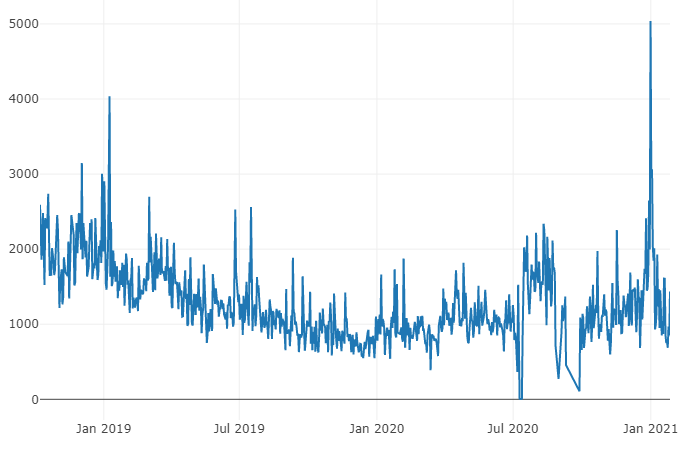
<br>
<b>Posts activity:</b>
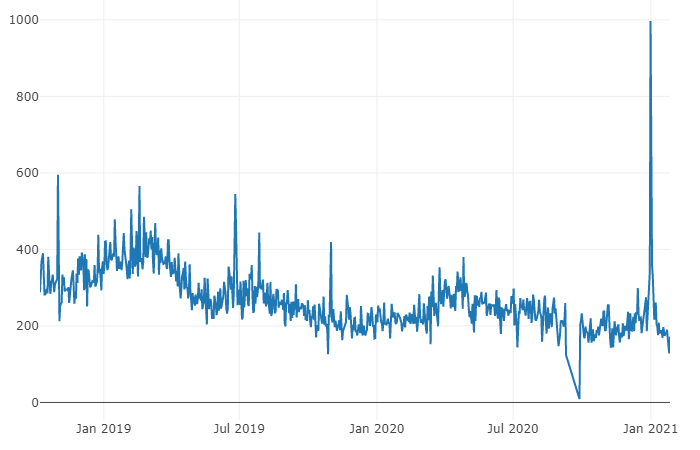